Let's specify the different specificities of our modell. We have to define the dimensions, and the specificities of each material:

In [688]:
!pip install numpy pandas matplotlib
import dm4bem


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\PC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [689]:
controller = False
neglect_air_glass_capacity = False
imposed_time_step = False
Δt = 498    # s, imposed time step

In [690]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

l =10               # m length of the room
L=5                 #Largeur of the room
H=2.5               #Height of the room
Hw=1.5              #Hauteur Window
Lw=0.9              #Longueur Window
Sp=3                #Surface porte
Sw = 2*Hw*Lw        # m² surface area of the windows
Sc = L*H+2*l*H-Sp+L*l   # m² surface area of plasterboard
Sout = L*H-Sw       # m² surface area of concrete & insulation of the walls
To=5
Ti=18
Tiop=22
Kp=1
q=15
θ=9

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': L*H-Sw}            # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.01,                # m
              'Surface': L*H-Sw}          # m²

plasterboard = {'Conductivity': 0.25,        # W/(m·K)
              'Density': 9.3,              # kg/m³
              'Specific heat': 500,        # J/(kg⋅K)
              'Width': 0.05,                # m
              'Surface': L*H+2*l*H-Sp+L*l}          # m²

glass = {'Conductivity': 1.4,               # W/(m·K)
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 0.04,                     # m
         'Surface': Hw*Lw}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation, 'Plasterboard':plasterboard,
                               'Glass': glass},
                              orient='index')

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
ε_pLW = 0.90    # long wave emmisivity: plasterboard
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

In [691]:
# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5', 'θ6', 'θ7','θ8','θ9']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11','q12','q13','q14','q15']

Thanks to the thermal circuit, we can define the matrix A as following:


In [692]:
A= np.array([
    [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [ 0, -1,  1,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0, -1,  1,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0, -1,  1,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0, -1,  0,  1,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  1, -1,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
    [ 0,  0,  0,  0,  0,  1, -1,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  1,  0,  0, -1],
    [ 0,  0,  0,  0,  0,  1,  0,  0, 0,  -1],
    [ 0,  0,  0,  0, -1,  1,  0,  0, 0,   0],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
    [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0]
])
pd.DataFrame(A, index=q, columns=θ)

,θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7,θ8,θ9
q0,1,0,0,0,0,0,0,0,0,0
q1,-1,1,0,0,0,0,0,0,0,0
q2,0,-1,1,0,0,0,0,0,0,0
q3,0,0,-1,1,0,0,0,0,0,0
q4,0,0,0,-1,1,0,0,0,0,0
q5,0,0,0,0,-1,0,1,0,0,0
q6,0,0,0,0,0,0,1,-1,0,0
q7,0,0,0,0,0,0,0,1,0,0
q8,0,0,0,0,0,1,-1,0,0,0
q9,0,0,0,0,0,0,1,0,0,-1


Then we can define the G matrix that corresponds to the conductances:

In [693]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

# convection
Gw_out = h * wall['Surface'].iloc[0]     # wall
Gw_in = h * wall['Surface'].iloc[2]     # wall
Gg = h * wall['Surface'].iloc[3]     # glass

# view factor glass-wall
Fgw = 1

#Factor wall_out-wall_in

Fwo_wi=1

Tm = 20 + 273   # K, mean temp for radiative exchange

#Long Wave radiation between glass and plasterboard wall
GLW1_2 = 4 * σ * Tm**3 * ε_pLW / (1 - ε_pLW) * wall['Surface']['Plasterboard']
GLW12_2 = 4 * σ * Tm**3 * Fgw * wall['Surface']['Glass']
GLW2_2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
GLW_2 = 1 / (1 / GLW1_2 + 1 / GLW12_2 + 1 / GLW2_2)

#Long wave radiation between insulated wall and plasterboard wall
GLW1_1 = 4 * σ * Tm**3 * ε_pLW / (1 - ε_pLW) * wall['Surface']['Plasterboard']
GLW12_1 = 4 * σ * Tm**3 * Fwo_wi * wall['Surface']['Layer_in']
GLW2_1 = 4 * σ * Tm**3 * ε_pLW / (1 - ε_pLW) * wall['Surface']['Layer_in']
GLW_1 = 1 / (1 / GLW1_1 + 1 / GLW12_1 + 1 / GLW2_1)

G0=Gw_out['out'].iloc[0]            #Convection between outside and concrete wall
G1=G2=G_cd['Layer_out']/2    #conductions in the concrete wall
G3=G4=G_cd['Layer_in']/2  #conduction in the insulator
G5=GLW_1                    #Long Wave radiation between the wall (insulation) and the plasterboard wall
G9=GLW_2                    #Long Wave radiation between the plasterboard wall and the glass
G6=G7=G_cd['Plasterboard']/2 #Conduction in the plasterboard
G8= Gw_in['in'].iloc[0]             #Convection from plasterboard
G10=Gg['in'].iloc[0]               #Convection from glass
G11=Gw_out['in'].iloc[0]           #Convection from the insulator
G12=G_cd['Glass']/2         #Conduction in glass
Gglass_conv=Gg['out'].iloc[0]       #Convection on the outside Window
G13=G12*Gglass_conv/(G12+Gglass_conv) #conduction and convection in glass
Va = l*L*H                  # m³, volume of air
ACH = 0.1                   # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

G14= air['Density'] * air['Specific heat'] * Va_dot # Advection

Glist=[G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,Kp]
G = np.array(np.hstack(
    [G0,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,G13,G14,Kp]))

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

,0
q0,245.000000
q1,34.300000
q2,34.300000
q3,13.230000
q4,13.230000
q5,49.870641
q6,273.750000
q7,273.750000
q8,876.000000
q9,6.922885


We also define the C matrix that represents the thermal capacities, the f matrix, whix corresponds to the fluxes and b that defines the initial temperatures

In [694]:
Etot=500 #irradiance in W/m2
Phi_glass=α_wSW*glass['Surface']*Etot
Phi_concrete=α_wSW*concrete['Surface']*Etot

In [695]:
# Temperature source vector
b = pd.Series([To, 0, 0, 0, 0, 0, 0, Ti, 0, 0, 0, 0, 0, To, Ti, Tiop],
              index=q)
f=np.zeros(10)
Qa=100
f[[0]]=Phi_concrete
f[[5]]=Qa
f[[9]]=Phi_glass
f = pd.Series([Phi_concrete,0,0,0,0,Qa,0,0,0,Phi_glass],
              index=θ)
f

θ0    1225.00
θ1       0.00
θ2       0.00
θ3       0.00
θ4       0.00
θ5     100.00
θ6       0.00
θ7       0.00
θ8       0.00
θ9     168.75
dtype: float64

In [696]:
# Air properties
air_density = 1.2      # kg/m³
air_cp = 1000          # J/(kg·K)
air_volume = l * L * H # m³
c_air = air_density * air_cp * air_volume

# Thermal capacity function
def thermal_capacity(material):
    volume = material['Surface'] * material['Width']
    return material['Density'] * material['Specific heat'] * volume

# Compute thermal capacities
c_concrete = thermal_capacity(concrete)
c_insulation = thermal_capacity(insulation)
c_plasterboard = thermal_capacity(plasterboard)
c_glass = thermal_capacity(glass)

# Assign to variables
c1 = c_concrete
c3 = c_insulation
c5 = c_air
c7 = c_plasterboard
C10 = c_plasterboard

# Diagonal matrix of thermal capacities with interleaved zeros
C = np.array([0, c1, 0, c3, 0, c5, 0, c7, 0, C10])



# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)

,0
θ0,0.00
θ1,3967040.00
θ2,0.00
θ3,6521.90
θ4,0.00
θ5,150000.00
θ6,0.00
θ7,25458.75
θ8,0.00
θ9,25458.75


Output: Nodes of interest

In [697]:
y = np.zeros(10)         # nodes
y[[5]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y)

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,1.0
6,0.0
7,0.0
8,0.0
9,0.0


State Representation

In [698]:
# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
#print (As,'\n', Bs,'\n', Cs,'\n', Ds,'\n', us)
print (us)


q0        5.00
q7       18.00
q13       5.00
q14      18.00
q15      22.00
θ0     1225.00
θ5      100.00
θ9      168.75
dtype: float64


We now have all the information to determine the steady state temperatures.

In [699]:
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ b + f)
print(f'θss = {np.around(θss, 2)} °C')

θss = [10.16 11.27 12.38 15.26 18.14 18.47 18.39 18.19 17.87 17.87] °C


Steady State from Space representation

In [712]:

bT = np.array([5, 18, 5, 22, 18])     # [To, To, To, Tisp]
fQ = np.array([1200, 30, 100])         # [Φo, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

uss = [   5   18    5   22   18 1200   30  100]


In [713]:
inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values[0])
print(f'yss = {yss:.2f} °C')

yss = 17.77 °C


Eigenvalues Analysis

In [714]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As

Time step

In [715]:
# time step
Δtmax = 2 * min(-1. / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)
dm4bem.print_rounded_time('dt', dt)

Δtmax = 101 s = 1.7 min
dt = 60 s


Settling time and duration

In [716]:
# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

t_settle = 450821 s = 125.2 h


In [717]:
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)
us['q0']='To'
us['q7']='Ti'
us['q13']='To'
us['q14']='Ti'
us['q15']='Tiop'
us['θ0']='Phi_concrete'
us['θ5']='Qa'
us['θ9']='Phi_glass'
duration=duration

duration = 453600 s = 126.0 h


Step response to outdoor temperature

    Effect of the weater

In [718]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps
print('n=',n)
# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-06-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")


n= 7560


In [719]:
from dm4bem import read_epw, sol_rad_tilt_surf
filename = '../weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = read_epw(filename, coerce_year=None)
# Extract the month and year from the DataFrame index with the format 'MM-YYYY'
month_year = data.index.strftime('%m-%Y')

# Create a set of unique month-year combinations
unique_month_years = sorted(set(month_year))

# Create a DataFrame from the unique month-year combinations
pd.DataFrame(unique_month_years, columns=['Month-Year'])
# select columns of interest
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]

# replace year with 2000 in the index 
weather_data.index = weather_data.index.map(
    lambda t: t.replace(year=2000))
# Define start and end dates
start_date = '1999-01-01 12:00'
end_date = '2000-07-02'         # time is 00:00 if not indicated

# Filter the data based on the start and end dates
weather_data = weather_data.loc[start_date:end_date]
del data

weather_data.index = weather_data.index.tz_convert(None)
To=[weather_data.asof(time[k])[0]for k in range(n)]
β = 90  #slope: straight wall
γ = 90 #azimuth: oriented to the south
ϕ = 45  #latitude: France
# Transform degrees in radians
β = β * np.pi / 180
γ = γ * np.pi / 180
ϕ = ϕ * np.pi / 180
Dir_Rad=[]
Dif_Rad=[]
Rad_Tot=[]
for k in range (n):
    dir_rad=weather_data.asof(time[k])[1]
    dif_rad=weather_data.asof(time[k])[2]
    d=time[k].dayofyear
    declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
    δ = declination_angle * np.pi / 180
    hour = time[k].hour
    minute = time[k].minute + 60
    hour_angle = 15 * ((hour + minute / 60) - 12)   # deg
    ω = hour_angle * np.pi / 180                    # rad
    theta = np.sin(δ) * np.sin(ϕ) * np.cos(β) \
    - np.sin(δ) * np.cos(ϕ) * np.sin(β) * np.cos(γ) \
    + np.cos(δ) * np.cos(ϕ) * np.cos(β) * np.cos(ω) \
    + np.cos(δ) * np.sin(ϕ) * np.sin(β) * np.cos(γ) * np.cos(ω) \
    + np.cos(δ) * np.sin(β) * np.sin(γ) * np.sin(ω)

    theta = np.array(np.arccos(theta))
    theta = np.minimum(theta, np.pi / 2)
    Dir_Rad.append(dir_rad*np.cos(theta))
    Dif_Rad.append(dif_rad* (1 + np.cos(β)) / 2)
    Rad_Tot.append(dir_rad*np.cos(theta)+dif_rad* (1 + np.cos(β)) / 2)
#To=[weather_data.loc[time[k]] for k in range (n)]

C:\Users\PC\AppData\Local\Temp\ipykernel_8180\1820791356.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  To=[weather_data.asof(time[k])[0]for k in range(n)]
C:\Users\PC\AppData\Local\Temp\ipykernel_8180\1820791356.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dir_rad=weather_data.asof(time[k])[1]
C:\Users\PC\AppData\Local\Temp\ipykernel_8180\1820791356.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dif_rad=weather_

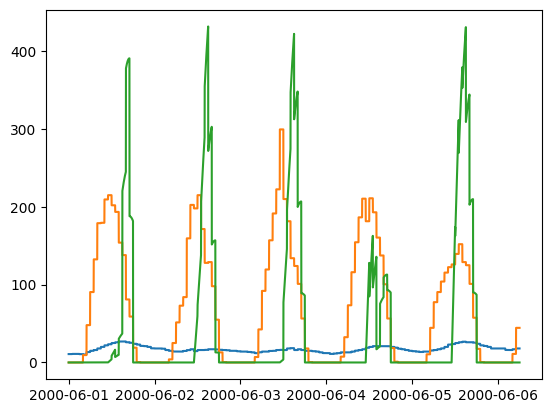

In [720]:

#To = 5 * np.ones(n)        # outdoor temperature
plt.plot(time,To)
plt.plot(time,Dif_Rad)
plt.plot(time,Dir_Rad)
plt.show()
Rad_Tot = np.array(Rad_Tot)
Phi_glass=α_wSW*glass['Surface']*(Rad_Tot)
Phi_concrete=α_wSW*concrete['Surface']*(Rad_Tot)
Tiop = 22 * np.ones(n)
Ti = 18 * np.ones(n)    # indoor temperature set point
Phi_concrete = 1225.00 * np.ones(n)         # solar radiation absorbed by the glass
Qa = 200.00* np.ones(n)
Phi_glass= 168.75* np.ones(n)           # auxiliary heat sources and solar radiation

data = {'To': To, 'Tiop': Tiop,'Ti':Ti, 'Phi_concrete': Phi_concrete, 'Qa': Qa, 'Phi_glass': Phi_glass}
input_data_set = pd.DataFrame(data, index=time)
# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [721]:
# Initial conditions
θ_exp = pd.DataFrame(index=u.index)     # empty df with index for explicit Euler
θ_imp = pd.DataFrame(index=u.index)     # empty df with index for implicit Euler

θ0 = 0.0                    # initial temperatures
θ_exp[As.columns] = θ0      # fill θ for Euler explicit with initial values θ0
θ_imp[As.columns] = θ0      # fill θ for Euler implicit with initial values θ0

I = np.eye(As.shape[0])     # identity matrix
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As)\
        @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])

In [722]:
# outputs
y_exp = (Cs @ θ_exp.T + Ds @  u.T).T
y_imp = (Cs @ θ_imp.T + Ds @  u.T).T

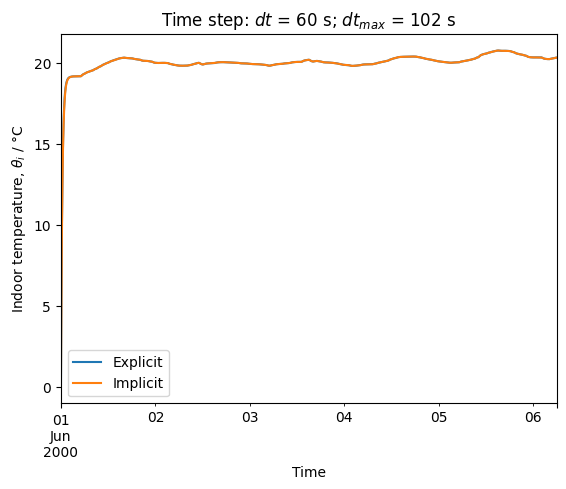

In [723]:
# plot results
y = pd.concat([y_exp, y_imp], axis=1, keys=['Explicit', 'Implicit'])
# Flatten the two-level column labels into a single level
y.columns = y.columns.get_level_values(0)

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {Δtmax:.0f} s')
plt.show()